# Fehlertoleranz der Spotify-Datenanalye

## Einführung
Fehlertoleranz ist ein zentraler Aspekt in verteilten Systemen wie Apache Spark. In diesem Notebook wird untersucht, wie robust diese Spark-Anwendung gegenüber Fehlern und Ausfällen ist.

**Dabei betrachten wir zwei Hauptaspekte:**

- **1. Fehlertoleranz im Code**
    - Bereits in der Implementierung wurden Maßnahmen ergriffen, um Fehler oder problematische Daten frühzeitig abzufangen.
    - Beispielsweise wurden bestimmte Daten gefiltert oder Bereinigungen vorgenommen, um spätere Fehler zu vermeiden.
    - Zudem nutzen einige Transformationen und Mechanismen von Spark bereits integrierte Fehlertoleranzmechanismen, die automatisch für eine stabilere Verarbeitung sorgen können.

- **1. Fehlertoleranz-Test**
    - Um die Stabilität der Spark-Anwendung zu bewerten, werden gezielt Fehlerfälle simuliert und ihr Einfluss auf die Anwendung analysiert. *(Am Ende des Notebooks)*

Das **Ziel dieses Notebooks** ist es, besser zu verstehen, wie gut die Anwendung mit Fehlern umgehen kann und welche potenziellen Schwachstellen existieren.

---

#### 1. Datenvorbereitung

Im folgenden Abschnitt werden lediglich die benötigten Datenquellen geladen und die Spark-Session initialisiert.  

**Hinweis:** Dieser Abschnitt dient ausschließlich der Datenvorbereitung.  
Die hier durchgeführten Operationen werden **nicht auf Skalierbarkeit getestet**.  
Die eigentlichen Skalierbarkeitstests beginnen in den folgenden Zellen.


In [1]:
import os
import time
import pickle
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, ArrayType, MapType, DoubleType
from pyspark.sql import functions as F
from pyspark.sql.functions import col, size, when, round

# Spark-Session erstellen
spark = SparkSession.builder.appName("PickleToDataFramewithRDD").getOrCreate()

# Verzeichnis mit den Pickle-Dateien
pickle_dir = "../100 Spotify Dataset"
# CSV-Datei in Spark laden
csv_path = "../data/main_final_dataset.csv"

schema = StructType([
    StructField("meta", MapType(StringType(), StringType()), True),
    StructField("track", StructType([
        StructField("num_samples", IntegerType(), True),
        StructField("duration", FloatType(), True),
        StructField("loudness", FloatType(), True),
        StructField("tempo", FloatType(), True),
        StructField("tempo_confidence", FloatType(), True),
        StructField("key", IntegerType(), True),
        StructField("key_confidence", FloatType(), True),
        StructField("mode", IntegerType(), True),
        StructField("mode_confidence", FloatType(), True),
        StructField("time_signature", IntegerType(), True),
        StructField("time_signature_confidence", FloatType(), True),
    ]), True),
    StructField("bars", ArrayType(StructType([
        StructField("start", FloatType(), True),
        StructField("duration", FloatType(), True),
        StructField("confidence", FloatType(), True),
    ])), True),
    StructField("beats", ArrayType(StructType([
        StructField("start", FloatType(), True),
        StructField("duration", FloatType(), True),
        StructField("confidence", FloatType(), True),
    ])), True),
    StructField("sections", ArrayType(StructType([
        StructField("start", FloatType(), True),
        StructField("duration", FloatType(), True),
        StructField("confidence", FloatType(), True),
        StructField("tempo", FloatType(), True),
        StructField("tempo_confidence", FloatType(), True),
        StructField("key", IntegerType(), True),
        StructField("key_confidence", FloatType(), True),
        StructField("mode", IntegerType(), True),
        StructField("mode_confidence", FloatType(), True),
        StructField("time_signature", IntegerType(), True),
        StructField("time_signature_confidence", FloatType(), True),
    ])), True),
    StructField("segments", ArrayType(StructType([
        StructField("start", FloatType(), True),
        StructField("duration", FloatType(), True),
        StructField("confidence", FloatType(), True),
        StructField("loudness_start", FloatType(), True),
        StructField("loudness_max", FloatType(), True),
        StructField("loudness_max_time", FloatType(), True),
        StructField("pitches", ArrayType(FloatType()), True),
        StructField("timbre", ArrayType(FloatType()), True),
    ])), True),
    StructField("tatums", ArrayType(StructType([
        StructField("start", FloatType(), True),
        StructField("duration", FloatType(), True),
        StructField("confidence", FloatType(), True),
    ])), True),
    StructField("track_uri", StringType(), True),
])

#### 2. Daten laden und verarbeiten  

Diese Zelle lädt eine CSV-Datei und mehrere Pickle-Dateien, verarbeitet sie parallel und führt sie über die `track_uri` zusammen.  
Fehlerhafte Einträge werden gefiltert.


In [2]:
# CSV File einlesen: quote berücksichtigt das Inhalte zwischen " " als eine Spalte genommen werden
csv_df = spark.read.option("header", True).option("quote", '"').option("inferSchema", True).csv(csv_path)

# Alle Pickle-Dateien sammeln
pickle_files = [os.path.join(pickle_dir, f) for f in os.listdir(pickle_dir) if f.endswith(".pkl") or f.endswith(".pickle")]

# RDD erstellen basierend auf der Liste der Pickle-Dateien
pickle_rdd = spark.sparkContext.parallelize(pickle_files)

# Funktion zur Verarbeitung einer einzelnen Pickle-Datei
def process_pickle(filepath):
    try:
        with open(filepath, "rb") as file:
            pickle_data = pickle.load(file)
        
        # Extrahiere die benötigten Felder
        return {
            "track_uri": pickle_data.get("track_uri", "Unbekannt"),
            "bars": pickle_data.get("bars", []),
            "duration_ms": pickle_data.get("duration_ms", "Unbekannt"),
            "sections": pickle_data.get("sections", []),
            "segments": pickle_data.get("segments", []),
            "loudness_max": pickle_data.get("loudness_max", "Unbekannt"),
            "keys": pickle_data.get("keys", []),
            "track": pickle_data.get("track", [])
        }
    except Exception as e:
        return {"track_uri": None, "error": str(e)}

# Pickle-Dateien parallel verarbeiten
processed_rdd = pickle_rdd.map(process_pickle)

# RDD in Spark DataFrame umwandeln
pickle_df = spark.createDataFrame(processed_rdd, schema=schema)

# Fehlerhafte Einträge herausfiltern
valid_pickle_df = pickle_df.filter(pickle_df.track_uri.isNotNull())

# CSV-Daten mit Pickle-Daten verbinden
combined_df = valid_pickle_df.join(csv_df, valid_pickle_df["track_uri"] == csv_df["track_uri_csv"], how="inner")

In [4]:
# Join-Information fürs Debugging
print(f"JOIN Information:")
print(f"- Zeilen vor Join: {valid_pickle_df.count()}")
print(f"- Zeilen nach Join: {combined_df.count()}")

# Statistik anzeigen
total_files = len(pickle_files)
successful_files = valid_pickle_df.count()
failed_files = total_files - successful_files

print(f"")
print(f"Erfolgs-Statistik:")
print(f"- Gesamtanzahl der Dateien: {total_files}")
print(f"- Erfolgreich verarbeitet: {successful_files}")
print(f"- Fehlerhaft: {failed_files}")

# Test, ob CSV und Pickle korrekt gejoint wurden: 
combined_df.select("track_uri", "track_uri_csv", "name", "duration_ms").show(n=10, truncate=False)

JOIN Information:
- Zeilen vor Join: 100
- Zeilen nach Join: 100

Erfolgs-Statistik:
- Gesamtanzahl der Dateien: 100
- Erfolgreich verarbeitet: 100
- Fehlerhaft: 0
+------------------------------------+------------------------------------+---------------------------------------------------------------+-----------+
|track_uri                           |track_uri_csv                       |name                                                           |duration_ms|
+------------------------------------+------------------------------------+---------------------------------------------------------------+-----------+
|spotify:track:1cm9uduXJUwIUOqIESdlsL|spotify:track:1cm9uduXJUwIUOqIESdlsL|Scarlatti, D: Sinfonia No. 5 in A Minor: I. Allegrissimo       |39067.0    |
|spotify:track:5E8djSHnmvGSnupEF6t35w|spotify:track:5E8djSHnmvGSnupEF6t35w|Are You Sitting Comfortably?                                   |209693.0   |
|spotify:track:3k8fUMuDZrKt2rrq5qD8Hz|spotify:track:3k8fUMuDZrKt2rrq5qD8Hz|I


---


#### 4. Berechnung des Modes (Major = 1 und Minor = 0) und daraus der Prozentsatz von Major (Dur)

In dieser Zelle wird der **Durchschnittsmodus** für alle Songs im Datensatz berechnet. Dabei wird der Anteil der Songs in einer **Dur-Tonart (Major)** als Prozentsatz ermittelt.  

In [10]:
# Berechnung des Durchschnittsmodus und Major-Prozentsatz für alle Songs
# Erstelle eine neue Spalte, die 1 ist, wenn der Modus 'Major' (1) ist, sonst 0
combined_df = combined_df.withColumn("is_major", F.when(combined_df["mode"] == 1, 1).otherwise(0))

# Gruppiere nach einer geeigneten Ebene (falls erforderlich, z.B. über alle Daten)
mode_stats = combined_df.agg(round(F.mean("is_major")*100,2).alias("major_percentage"))

# Ergebnisse anzeigen
mode_stats.show()

+----------------+
|major_percentage|
+----------------+
|            65.0|
+----------------+



#### 5. Berechnung von Spaltenwerten und Sortierung  

In dieser Zelle werden verschiedene neue Spalten berechnet, darunter die **Dauer in Sekunden**, die **Anzahl der Segmente pro Sekunde** und der **Kehrwert der Sections pro Sekunde**. Anschließend wird die Tabelle anhand der berechneten Werte sortiert. Zusätzlich wird die **Korrelation zwischen Sections und Segments pro Sekunde** ermittelt.


In [11]:
# Berechnung der benötigten Spalten und Sortierung
results_df = combined_df.select(
    "name",
    (col("duration_ms").cast("float") / 1000).alias("duration_sec"),  # Dauer in Sekunden
    when(col("duration_ms") > 0, 1 / (size(col("sections")) / (col("duration_ms").cast("float") / 1000))).otherwise(None).alias("Anzahl Sekunden pro Section (Kehrwert)"),  #Kehrwert sections pro Sekunde 
    when(col("duration_ms") > 0, size(col("segments")) / (col("duration_ms").cast("float") / 1000)).otherwise(0).alias("segments_pro_sekunde")
).orderBy(col("Anzahl Sekunden pro Section (Kehrwert)").desc())  # Sortierung nach Sekunden pro Section absteigend

# Berechnung der Korrelation zwischen sections_pro_sekunde und segments_pro_sekunde
correlation = results_df.stat.corr("Anzahl Sekunden pro Section (Kehrwert)", "segments_pro_sekunde")

# Ausgabe der Korrelation
print(f"Korrelation zwischen sections_pro_sekunde und segments_pro_sekunde: {correlation}")

# Ergebnisse anzeigen
results_df.show(truncate=False)

Korrelation zwischen sections_pro_sekunde und segments_pro_sekunde: 0.17678991397021485
+---------------------------------------------------------------+------------+--------------------------------------+--------------------+
|name                                                           |duration_sec|Anzahl Sekunden pro Section (Kehrwert)|segments_pro_sekunde|
+---------------------------------------------------------------+------------+--------------------------------------+--------------------+
|Sabor de Mel                                                   |322.16      |46.02285714285715                     |3.734169356841321   |
|Adi Shakti - Jungle Kitchen Remix                              |256.264     |42.71066666666667                     |4.99484906190491    |
|Scarlatti, D: Sinfonia No. 5 in A Minor: I. Allegrissimo       |39.067      |39.067                                |4.505081014667111   |
|Torno a respirare                                              |151.311     |

#### 6. Korrelationen zwischen Energy, Loudness Max und Danceability  

In dieser Zelle werden die **Zusammenhänge zwischen den musikalischen Merkmalen "Energy", "Loudness Max" und "Danceability"** untersucht. Dazu wird die geschachtelte `segments`-Spalte explodiert, um für jeden Song die maximale Lautstärke (`loudness_max`) zu extrahieren. Anschließend werden die Werte gefiltert, um ungültige Einträge zu entfernen, und die Korrelationen zwischen den Variablen berechnet.

In [12]:
# Schritt 1: Sicherstellen, dass die Spalten den Typ "double" haben
combined_df = combined_df.withColumn("energy", combined_df["energy"].cast("double")).withColumn("danceability", combined_df["danceability"].cast("double"))

# Schritt 2: Explodieren der "segments"-Spalte und Extrahieren von "loudness_max"
# Hier Zugriff auf Information der Pickle Datei: Da diese eine geschachtelte Struktur enthält, muss zunächst auf Segments zugegriffen werden und anschließend auf loudness max
exploded_df = combined_df.withColumn("segment", F.explode("segments")).withColumn("loudness_max_segment", F.col("segment.loudness_max").cast("double"))

# Schritt 3: Filtern der Zeilen, um null-Werte zu vermeiden und Berechnung der Korrelationen
filtered_df = exploded_df.filter((F.col("energy").isNotNull()) & (F.col("danceability").isNotNull()) & (F.col("loudness_max_segment").isNotNull()))

# Berechnung der Korrelationen
correlation_energy_loudness_max = filtered_df.stat.corr("energy", "loudness_max_segment")
correlation_loudness_max_danceability = filtered_df.stat.corr("loudness_max_segment", "danceability")
correlation_energy_danceability = filtered_df.stat.corr("energy", "danceability")

# Ausgabe der Korrelationen
print(f"Korrelation zwischen Energy und Loudness Max: {correlation_energy_loudness_max}")
print(f"Korrelation zwischen Loudness Max und Danceability: {correlation_loudness_max_danceability}")
print(f"Korrelation zwischen Energy und Danceability: {correlation_energy_danceability}")

Korrelation zwischen Energy und Loudness Max: 0.5608524753416664
Korrelation zwischen Loudness Max und Danceability: 0.19419580371052464
Korrelation zwischen Energy und Danceability: 0.1489083455487576


#### 7. Visualisierung von Zusammenhängen zwischen Energy, Loudness Max und Danceability  

In dieser Zelle werden die zuvor berechneten Werte für **Energy, Loudness Max und Danceability** visualisiert. Dazu wird eine Stichprobe von **10.000 Datenpunkten** gezogen, die in ein Pandas DataFrame umgewandelt wird. Anschließend werden **Hexbin-Diagramme** erstellt, um die Dichteverteilung der Punkte für verschiedene Merkmalskombinationen zu analysieren.


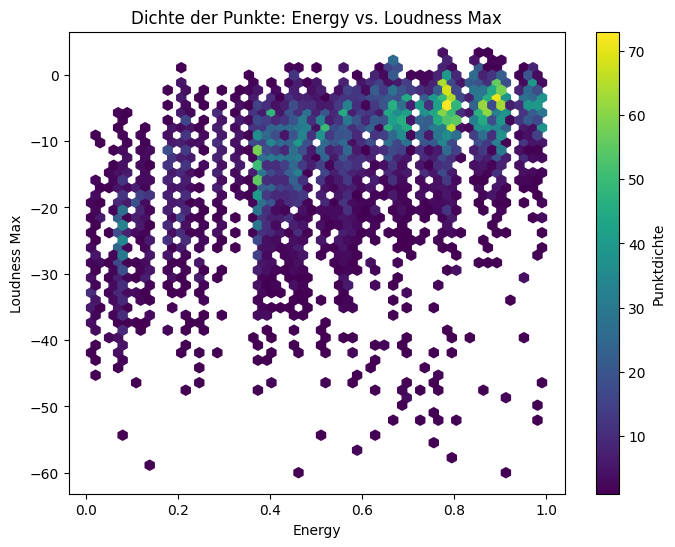

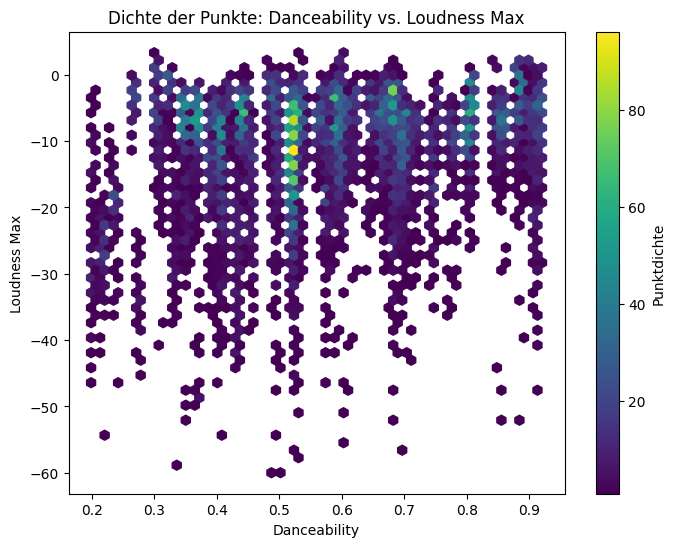

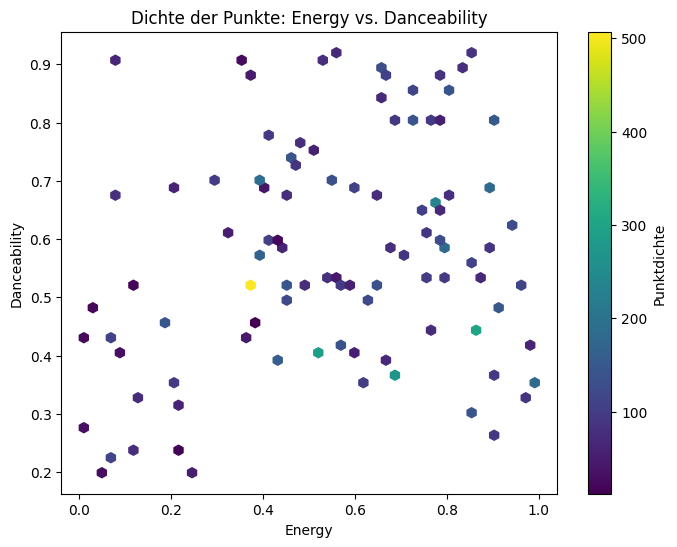

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np

# Spark DataFrame vorbereiten
filtered_df = filtered_df.select(
    col("energy").cast("float"),
    col("loudness_max_segment").cast("float"),
    col("danceability").cast("float")
).na.drop()

# Sampling der Daten (10.000 Zeilen für Visualisierung)
sample_size = 10000
sampled_df = filtered_df.sample(fraction=sample_size / filtered_df.count())

# Umwandeln der Stichprobe in Pandas DataFrame
filtered_pd_df = sampled_df.toPandas()

# Visualisierung 1: Hexbin-Dichteplot für Energy vs. Loudness Max
plt.figure(figsize=(8, 6))
plt.hexbin(filtered_pd_df["energy"], filtered_pd_df["loudness_max_segment"], gridsize=50, cmap="viridis", mincnt=1)
plt.colorbar(label="Punktdichte")
plt.title("Dichte der Punkte: Energy vs. Loudness Max")
plt.xlabel("Energy")
plt.ylabel("Loudness Max")
plt.show()

# Visualisierung 2: Hexbin-Dichteplot für Danceability vs. Loudness Max
plt.figure(figsize=(8, 6))
plt.hexbin(filtered_pd_df["danceability"], filtered_pd_df["loudness_max_segment"], gridsize=50, cmap="viridis", mincnt=1)
plt.colorbar(label="Punktdichte")
plt.title("Dichte der Punkte: Danceability vs. Loudness Max")
plt.xlabel("Danceability")
plt.ylabel("Loudness Max")
plt.show()


#Visualisierung 3: Energy vs. Danceability
plt.figure(figsize=(8, 6))
plt.hexbin(filtered_pd_df["energy"], filtered_pd_df["danceability"], gridsize=50, cmap="viridis", mincnt=1)
plt.colorbar(label="Punktdichte")
plt.title("Dichte der Punkte: Energy vs. Danceability")
plt.xlabel("Energy")
plt.ylabel("Danceability")
plt.show()

## Testumgebung

Da die lokale Ausführung der Spark-Anwendung nicht ausreichte, um realistische Fehlertoleranz-Szenarien zu testen, wurde stattdessen Spark im **Standalone-Modus** eingerichtet. Die folgenden Hard- und Software-Spezifikationen wurden für die Fehlertoleranz-Tests verwendet:  

- **1 Master Node**
- **4 Worker Nodes**
    - **RAM**: 4 GB
    - **CPU-Kerne**: 2

Wenn Größen im Test angepasst,verändert oder ganz weggelassen wurde, wurden dies explizit angegeben.

## Zielsetzung
Der Test soll zeigen, wie sich die Spark-Anwendung verhält, wenn:  
1. während einer Spark-Anwendung **Worker-Nodes ausfallen**
2. das **Netzwerk ausfällt**
3. **Worker-Nodes stark ungleichmäßig belastet werden**  
4. **iwas mit ram**  

Im weiteren Verlauf dieses Notebooks werden die Testergebnisse analysiert und visualisiert.

### **1. Fehlertoleranz-Test: Worker-Ausfall**

Der erste Test untersucht die **Fehlertoleranz einer Spark-Anwendung**, wenn während der Laufzeit **Worker-Nodes ausfallen**. Ziel dieses Tests ist es, die Auswirkungen solcher plötzlichen Ausfälle zu analysieren und zu verstehen, wie Spark mit diesen umgeht.

#### **Fragestellung**
- **Was passiert, wenn Worker-Nodes in einer laufenden Spark-Anwendung ausfallen?**
- **Kann die Anwendung den Betrieb stabil fortsetzen?**

#### **Durchführung**
In einem Experiment wurden **zwei Worker-Nodes deaktiviert**, während eine Spark-Anwendung bereits seit **1 Minute** mit **1000 Dateien** lief. Die Deaktivierung wurde simuliert, indem die entsprechenden **cmd-Fenster der Worker geschlossen** wurden.

#### **Ergebnisse und Beobachtungen**

1. **Normale Verarbeitung (alle Worker aktiv)**  
   Zu Beginn des Tests waren alle **4 Worker aktiv**. Jeder Worker bearbeitete dabei **2 Tasks parallel**. Dies entsprach der ursprünglichen Konfiguration mit **2 CPU-Kernen pro Worker**.

   <img src="../data/images/workerall.png" alt="Alle Worker aktiv" width="600">

   *Abbildung: Taskbearbeitung bei 4 aktiven Workern (je 2 parallele Tasks pro Worker)*

2. **Ausfall von zwei Workern**  
   Nach der Deaktivierung von zwei Workern wurden die laufenden Tasks der betroffenen Worker **fehlgeschlagen**. Diese fehlerhaften Tasks wurden jedoch automatisch von den verbleibenden Workern neu übernommen und erfolgreich beendet.

   <img src="../data/images/workerloss1.png" alt="Worker-Ausfall sichtbar" width="600">

   *Abbildung: Ausfall von zwei Workern sichtbar in der Spark-UI*

   <img src="../data/images/workerloss2.png" alt="Fehlgeschlagene Tasks übernommen" width="600">

   *Abbildung: Neuverteilung der fehlgeschlagenen Tasks auf die verbleibenden Worker*

3. **Verarbeitung mit verbleibenden Workern**  
   Nach dem Ausfall wurden **alle weiteren Tasks** von den **verbleibenden zwei Workern** bearbeitet. 

   <img src="../data/images/workerleft.png" alt="Bearbeitung durch verbleibende Worker" width="600">

   *Abbildung: Taskbearbeitung nach dem Ausfall - übrig gebliebene Worker übernehmen Workload von den ausgefallenen Workern*

#### **Fazit**
Der Test zeigt, dass die Spark-Anwendung nach einem **Worker-Ausfall stabil weiterläuft**, indem die fehlgeschlagenen Tasks auf die verbleibenden Worker verteilt werden. Allerdings verlängerte sich dadurch die Durchlaufzeit der Ausführung, da die Anzahl an parallelen Tasks pro Worker immernoch bei 2 Tasks blieb.

---

### **2. Fehlertoleranz-Test: Netzwerk-Ausfall**
#### **Fragestellungen:**
- Wie reagiert Spark, wenn die Verbindung zwischen einem Worker-Node und dem Master während der Laufzeit unterbrochen wird?
- Verteilt Spark die betroffenen Tasks neu und setzt die Verarbeitung stabil fort?

#### Durchführung:
In einem weiteren Experiment wurde mit dem selben **Standalone-Spark-Cluster** mit **1 Master** und **4 Worker-Nodes**.
- Zugriff auf die **Kommandozeile der Nodes** (entweder lokal oder per SSH).
